In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [24]:
df_app = pd.read_csv('AppRNN.csv', index_col='Date', parse_dates=['Date']) # 导入数据

# 按照2020年10月10日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values # 训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values # 测试集

from sklearn.preprocessing import MinMaxScaler # 导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0, 1)) # 创建缩放器
Train = Scaler.fit_transform(Train) # 拟合缩放器并对训练集进行归一化

# 对测试数据进行归一化处理
Test = Scaler.transform(Test)

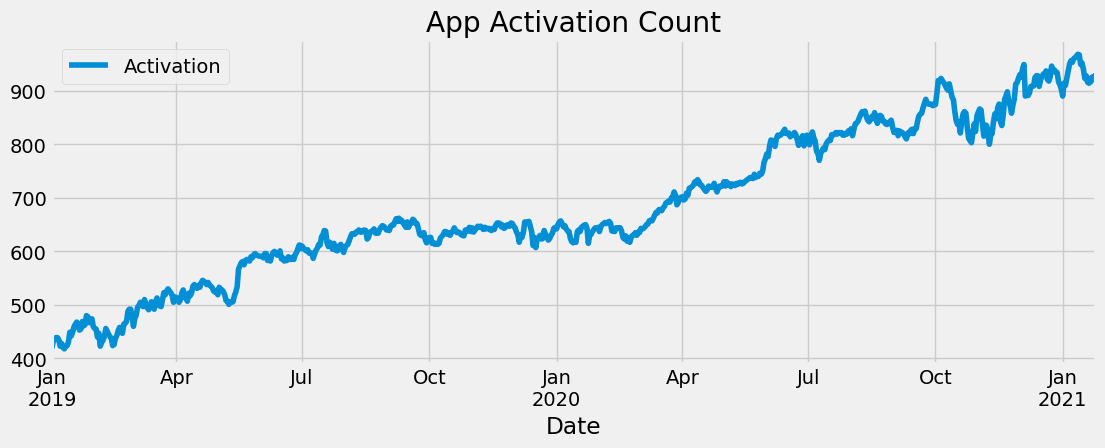

In [25]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot
plt.style.use('fivethirtyeight') # 设定绘图风格
df_app['Activation'].plot(figsize=(12, 4),legend=True) # 绘制激活数
plt.title('App Activation Count') # 图题
plt.show() # 绘图

In [26]:
# 创建一个函数，将数据集转换为时间序列格式
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# 设定窗口大小
seq_length = 4

x_train, y_train = sliding_windows(Train, seq_length)
# 使用滑动窗口为测试数据创建特征和标签
x_test, y_test = sliding_windows(Test, seq_length)

# 将数据转换为torch张量
testX = Variable(torch.Tensor(np.array(x_test)))
testY = Variable(torch.Tensor(np.array(y_test)))

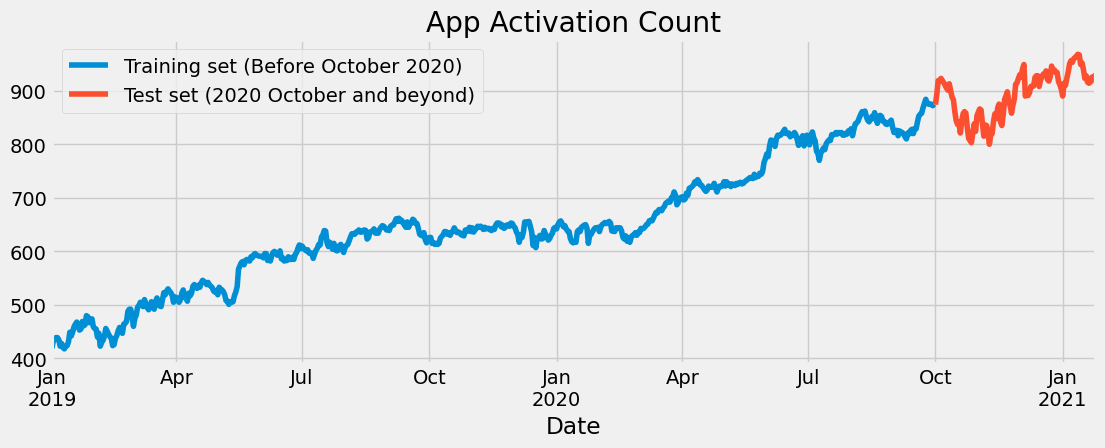

In [27]:
# 以不同的颜色为训练集和测试集绘画
df_app['Activation'][:'2020-09-30'].plot(figsize=(12, 4),legend=True)
df_app['Activation']['2020-10-01':].plot(figsize=(12, 4),legend=True)
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)'])
plt.title('App Activation Count') # 图题
plt.show() #绘图

In [28]:
# 设置模型
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        #RNN 层
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐状态
        h0 = Variable(torch.zeros(num_layers, x.size(0), self.hidden_size))

        # 前向传播
        out, _ = self.rnn(x, h0)

        #解码RNN最后一个隐藏层的输出
        out = self.fc(out[:, -1, :])

        return out

In [29]:
# 创建模型
rnn = RNN(input_size, hidden_size, num_layers, output_size)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss() # 均方误差
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) # Adam优化器

# 将数据转化为torch张量
trainX = Variable(torch.Tensor(np.array(x_train)))
trainY = Variable(torch.Tensor(np.array(y_train)))

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad()

    # 计算损失
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()
    if epoch %  10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.35215
Epoch: 10, loss: 0.02283
Epoch: 20, loss: 0.01206
Epoch: 30, loss: 0.00177
Epoch: 40, loss: 0.00173
Epoch: 50, loss: 0.00063
Epoch: 60, loss: 0.00069
Epoch: 70, loss: 0.00058
Epoch: 80, loss: 0.00053
Epoch: 90, loss: 0.00051


In [30]:
# 使用训练好的模型进行预测
rnn.eval() # 设置模型为评估模式
test_outputs = rnn(testX)

# 将预测结果拟归一化
test_outputs = test_outputs.data.numpy()
test_outputs = Scaler.inverse_transform(test_outputs) # 逆归一化

# 真实测试标签逆归一化
y_test_actual = Scaler.inverse_transform(y_test)

# 输出预测和真实结果
for i in range(len(y_test)):
    print(f"Date: {df_app['2020-10-01':].index[i+seq_length]}, Actual Activation: {y_test_actual[i][0]}, Predicted Activation: {test_outputs[i][0]}")

Date: 2020-10-05 00:00:00, Actual Activation: 923.0, Predicted Activation: 885.451416015625
Date: 2020-10-06 00:00:00, Actual Activation: 919.0000000000001, Predicted Activation: 894.3280639648438
Date: 2020-10-07 00:00:00, Actual Activation: 915.0, Predicted Activation: 901.7301635742188
Date: 2020-10-08 00:00:00, Actual Activation: 910.0000000000001, Predicted Activation: 899.8016357421875
Date: 2020-10-09 00:00:00, Actual Activation: 905.0000000000001, Predicted Activation: 899.1792602539062
Date: 2020-10-10 00:00:00, Actual Activation: 901.0, Predicted Activation: 895.5458984375
Date: 2020-10-11 00:00:00, Actual Activation: 913.0000000000001, Predicted Activation: 892.1752319335938
Date: 2020-10-12 00:00:00, Actual Activation: 900.0, Predicted Activation: 893.6489868164062
Date: 2020-10-13 00:00:00, Actual Activation: 888.0000000000001, Predicted Activation: 889.3714599609375
Date: 2020-10-14 00:00:00, Actual Activation: 883.0, Predicted Activation: 882.9586791992188
Date: 2020-10-

In [31]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red', label="Real Count") # 真值
    plt.plot(predicted, color='blue', label="Predicted Count") # 预测值
    plt.title('Flower App Activation Prediction')
    plt.xlabel('Time')
    plt.ylabel('Flower App Activation Count')
    plt.legend() # 图例
    plt.show()

    plot_predictions(y_test_actual,test_outputs) # 绘图

In [32]:
import math # 导入数学函数
from sklearn.metrics import mean_squared_error
def return_rmse(test,predicted): # 定义军方损失函数
    rmse = math.sqrt(mean_squared_error(test, predicted)) # 均方损失
    print("MS损失值 {}.".format(rmse))
return_rmse(y_test_actual, test_outputs)

MS损失值 24.172187720718192.


In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_actual, test_outputs)
print(f"R2 Sorce: {r2}")

R2 Sorce: 0.6921790922309826
